In [15]:
import casadi as ca
from dynamics_hybrid import f
import numpy as np
import matplotlib.pyplot as plt
from plotting import visualize

In [16]:
def F_step(f,dt):
    f = f.expand()
    x, u, p, c1, c2 = f.mx_in()
    dxdt, lam_out, c1_next, c2_next, dq_plus = f(x, u, p, c1, c2)
    ode = {'x': x, 'u': u, 'p': ca.vertcat(p, c1, c2), 'ode': dxdt}
    intg = ca.integrator('intg', 'rk', ode, 0, dt, {'simplify': True})
    res = intg(x0=x, u=u, p=ca.vertcat(p, c1, c2))
    F = ca.Function('F',
                    [x, u, p, c1, c2],[res['xf']],
                    ['x','u','p','c1','c2'],['xnext'])
    return F

def forward(x0,u,p,F,dt,N):
    k_td = None
    c1,c2 = 0.0,0.0 #starting airbourne
    x_ = [np.array(x0.T).flatten()]  # list of 8-dim states
    t_  = [0.0]
    c1_ = [c1]
    c2_ = [c2]
    x = x0
    for k in range(N):
        _,_,c1_next,c2_next,dq_plus = f(x, u, p, c1, c2)
        #detect event → reset state → integrate → update mode
        #c1_next,c2_next: What the contact flags will be in the NEXT state
        #dq_plus: IF touchdown occurs, this is the CURRENT dq
        touchdown = ((c1 < 0.5 and float(c1_next) > 0.5) or (c2 < 0.5 and float(c2_next) > 0.5))
        if touchdown:
            x[4:8] = dq_plus #set velocity to correct value
        x = F(x, u, p, c1, c2) #integration to the next state using correct current velocity
        if touchdown:
            k_td = k+1
        c1, c2 = c1_next, c2_next #set contact flags to what they should be as predicted by f
        x_.append(np.array(x.T).flatten())
        c1_.append(float(c1_next))
        c2_.append(float(c2_next))
        t_.append((k+1)*dt)
    return x_,t_,k_td,c1_,c2_

def plot(x_,t_,c1_,c2_):
    #Plotting
    plt.figure(figsize=(9,4))
    plt.subplot(2,1,1)
    plt.plot(np.array(t_), np.array(x_)[:,1], label='rCM_z (vertical)')
    plt.ylabel('Height [m]')
    plt.legend()
    plt.grid(True)

    plt.subplot(2,1,2)
    plt.plot(np.array(t_), np.array(c1_), label='c1')
    plt.plot(np.array(t_), np.array(c2_), label='c2')
    plt.ylabel('Contact flags')
    plt.xlabel('Time [s]')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Contact after time ( 6 steps).


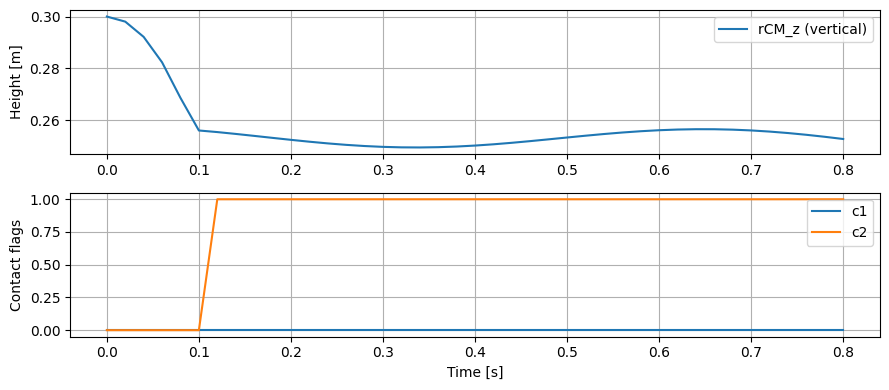

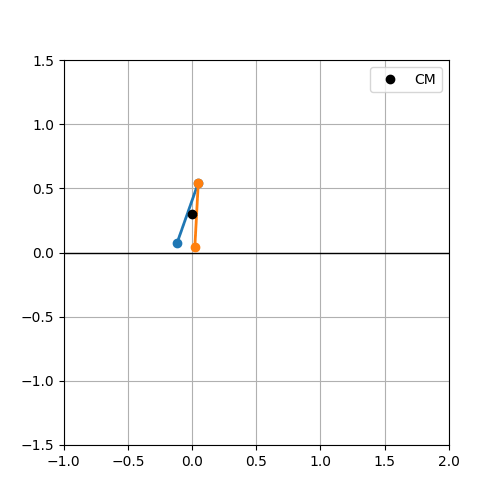

In [17]:
p = ca.DM([1,2,0.5,0,1,0,9.81]) #parameters: [m,M,l,k,kappa,J,g]
dt = 0.02
N = 32
x0 = ca.DM([0,0.3,np.pi-np.pi/16,np.pi/11,0,0,0,0]) #initial state: [rCMy,rCMz,qmean,qrel,vCMy,vCMz,dqmean,dqrel]
x_,t_,k_td,c1_,c2_ = forward(x0,0,p,F_step(f,dt),dt,N)
print('Contact after time (',k_td,'steps).')
plot(x_,t_,c1_,c2_)
#print(np.argmax(np.array(x_)[10:,1]))
visualize(x_,c1_,c2_,t_,dt,p)

In [18]:
#optimal control setup
def setup_ocp(F,x0,xf,xguess_,uguess_,p_val,c1,c2,N):
    opti = ca.Opti()
    #variables and parameters
    x_ = opti.variable(8,N+1)
    u_ = opti.variable(1,N)
    p = opti.parameter(7)
    opti.set_value(p,p_val)

    #constraints
    opti.subject_to( x_[:,0]==x0 ) #initial state constraint
    for k in range(N):
        x_next = F(x_[:,k],u_[:,k],p,float(c1),float(c2)) #integration
        opti.subject_to( x_[:,k+1]==x_next ) #continuity constraints
    opti.subject_to( x_[:,N]==xf ) #terminal state constraint

    #objective
    opti.minimize(ca.sumsqr(u_))

    #initial guess
    opti.set_initial(x_, xguess_)
    opti.set_initial(u_, uguess_)

    opti.solver('ipopt',{'expand': False,'print_time': True,},
                {'tol': 1e-5,'max_iter': 200,'print_level': 3,'sb': 'yes',
                 "hessian_approximation": "limited-memory"})
    return opti,x_,u_

In [19]:
#setup parameters
p_val = p
c1,c2 = c1_[k_td],c2_[k_td]
print(c1,c2)
N = N - k_td #timesteps from touchdown until final state

#setup initial and final states
x0,xf = x_[k_td],x_[k_td+N]

#small, but feasible changes
del_phi1 = 0.001
del_phi2 = 0.001
del_qmean = (del_phi1+del_phi2)/2
del_qrel = del_phi2-del_phi1
xf[2] += del_qmean
xf[3] += del_qrel

#mirroring
#xf[2] = 2*np.pi - x0[2] #mirror qmean: from approx. pi-pi/16 to approx. pi+pi/16
#xf[3] = -x0[3] #mirror qrel: from pi/11 to -pi/11
#xf[6] = -x0[6] #also mirror velocities
#xf[7] = -x0[7]

#setup initial guess
xguess_ = np.array(x_)[k_td:k_td+N+1,:] # (N+1, 8) array
xguess_ = ca.DM(xguess_.T) # transpose to 8×(N+1) and convert to DM
uguess_ = ca.DM.zeros(1, N)

#insert into ocp
opti,xsym_,usym_ = setup_ocp(F_step(f,dt),x0,xf,xguess_,uguess_,p_val,c1,c2,N)

0.0 1.0


In [20]:
sol = opti.solve()
xopt_ = sol.value(xsym_)
uopt_ = sol.value(usym_)

Total number of variables............................:      314
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      288
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 41

                                   (scaled)                 (unscaled)
Objective...............:   2.9346992298592028e-01    2.9346992298592028e-01
Dual infeasibility......:   5.2691197643327792e-01    5.2691197643327792e-01
Constraint violation....:   6.6640796199800290e-05    6.6640796199800290e-05
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementari

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:217:
.../casadi/core/optistack_internal.cpp:1338: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'

(8, 26)


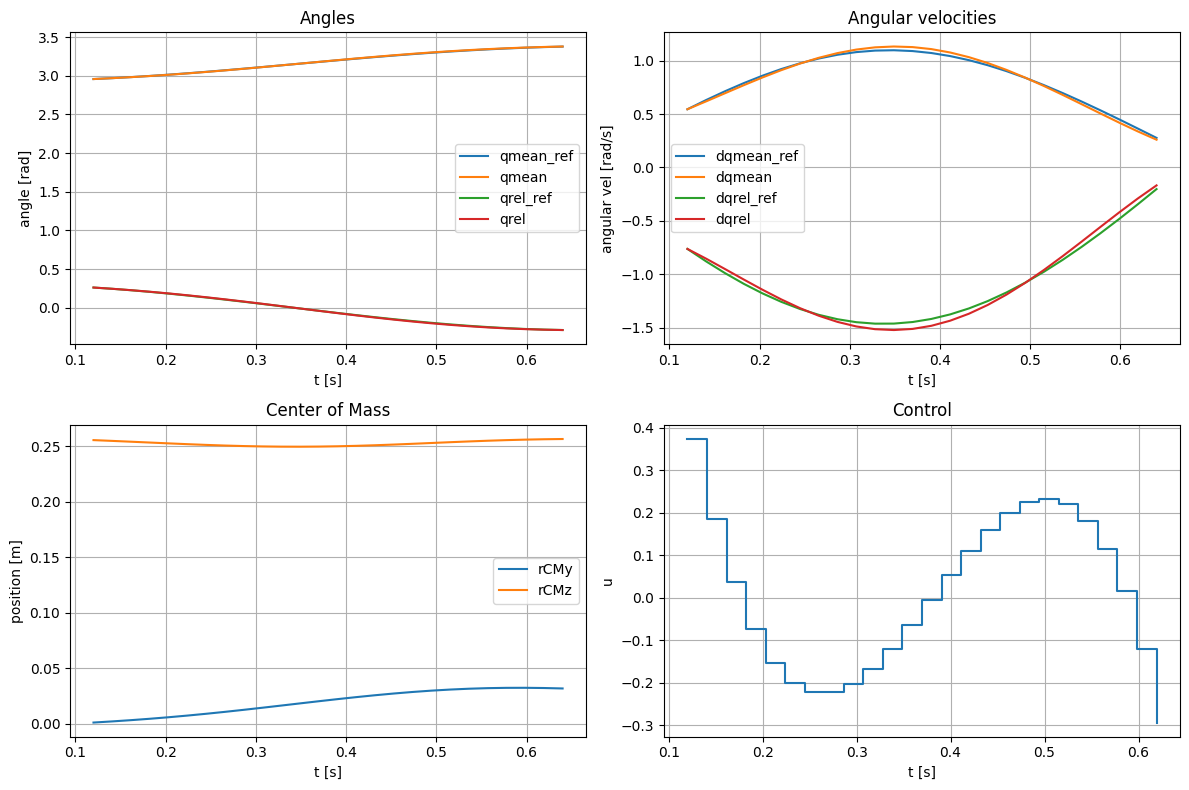

In [13]:
# Convert CasADi DMs to numpy
xopt_plt = np.array(xopt_)[:,:-1]        # shape (8, N+1) to shape (8, N)
uopt_plt = np.array(uopt_).reshape(1, -1)  # shape (1, N)
t = np.linspace(t_[k_td],t_[k_td+N],N)

xref_plt = np.array(x_)[k_td:-1].T
print(xref_plt.shape)

plt.figure(figsize=(12,8))

# 1) Angles vs ref
plt.subplot(2,2,1)
plt.plot(t, xref_plt[2], label='qmean_ref')
plt.plot(t, xopt_plt[2], label='qmean')
plt.plot(t, xref_plt[3], label='qrel_ref')
plt.plot(t, xopt_plt[3], label='qrel')
plt.xlabel('t [s]')
plt.ylabel('angle [rad]')
plt.title('Angles')
plt.legend()
plt.grid(True)

# 2) Angular velocities vs ref
plt.subplot(2,2,2)
plt.plot(t, xref_plt[6], label='dqmean_ref')
plt.plot(t, xopt_plt[6], label='dqmean')
plt.plot(t, xref_plt[7], label='dqrel_ref')
plt.plot(t, xopt_plt[7], label='dqrel')
plt.xlabel('t [s]')
plt.ylabel('angular vel [rad/s]')
plt.title('Angular velocities')
plt.legend()
plt.grid(True)

# 3) CM position
plt.subplot(2,2,3)
plt.plot(t, xopt_plt[0], label='rCMy')
plt.plot(t, xopt_plt[1], label='rCMz')
plt.xlabel('t [s]')
plt.ylabel('position [m]')
plt.title('Center of Mass')
plt.legend()
plt.grid(True)

# 4) Control
plt.subplot(2,2,4)
plt.step(t[:-1], uopt_plt[0,:-1], where='post')
plt.xlabel('t [s]')
plt.ylabel('u')
plt.title('Control')
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
# NEXT: try inverse-dynamics seed in stance coordinates (phi1, phi2)